# ###########################################################################################################
#     <span style="color:RED">        Author:  </span>
# <span style="color:green">     NIKOLIN       PRENGA </span>
# 
# ############################################################################################################

In [23]:
import Extract_Data 
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
import pandas as pd
import warnings
from sklearn.metrics import roc_curve
from sklearn import metrics
import scipy.special

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, Accuracy, AUC


# Ignore all warnings
warnings.filterwarnings("ignore")

### <span style="color:blue"> Import labest and datasets for both training and testing </span>


In [2]:
# Import labest and datasets for both training and testing
X_test = Extract_Data.X_test_shuffled
Y_test = Extract_Data.Y_test_shuffled
X_train = Extract_Data.X_train_shuffled
Y_train = Extract_Data.Y_train_shuffled
labels_train = Extract_Data.Labels_train_shuffled
labels_test = Extract_Data.Labels_test_shuffled



In [24]:
print('Traning dataset shape: ', X_train.shape)
print('Traning Labels shape: ', Y_train.shape)
print('Testing dataset shape: ', X_test.shape)
print('Testing labels shape: ', Y_test.shape)

Traning dataset shape:  (2583, 200, 200, 3)
Traning Labels shape:  (2583,)
Testing dataset shape:  (394, 200, 200, 3)
Testing labels shape:  (394,)


### <span style="color:blue"> Split the training dataset into training and validation sets </span>

In [4]:
# Split the training dataset into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

print("Training dataset shape:", X_train.shape)
print("Training Labels shape:", Y_train.shape)
print("Validation dataset shape:", X_val.shape)
print("Validation labels shape:", Y_val.shape)


Training dataset shape: (2583, 200, 200, 3)
Training Labels shape: (2583,)
Validation dataset shape: (287, 200, 200, 3)
Validation labels shape: (287,)


# 

# Python dictionary to facilitate identification of the tumor type by the reader.

In [25]:
# Class names
class_names = {
    0: "No Tumor",
    1: "Glioma Tumor",
    2: "Meningioma tumor",
    3: "Pituitary tumor"
}

#  #######################################################################################################
# Show 9 images
# #######################################################################################################

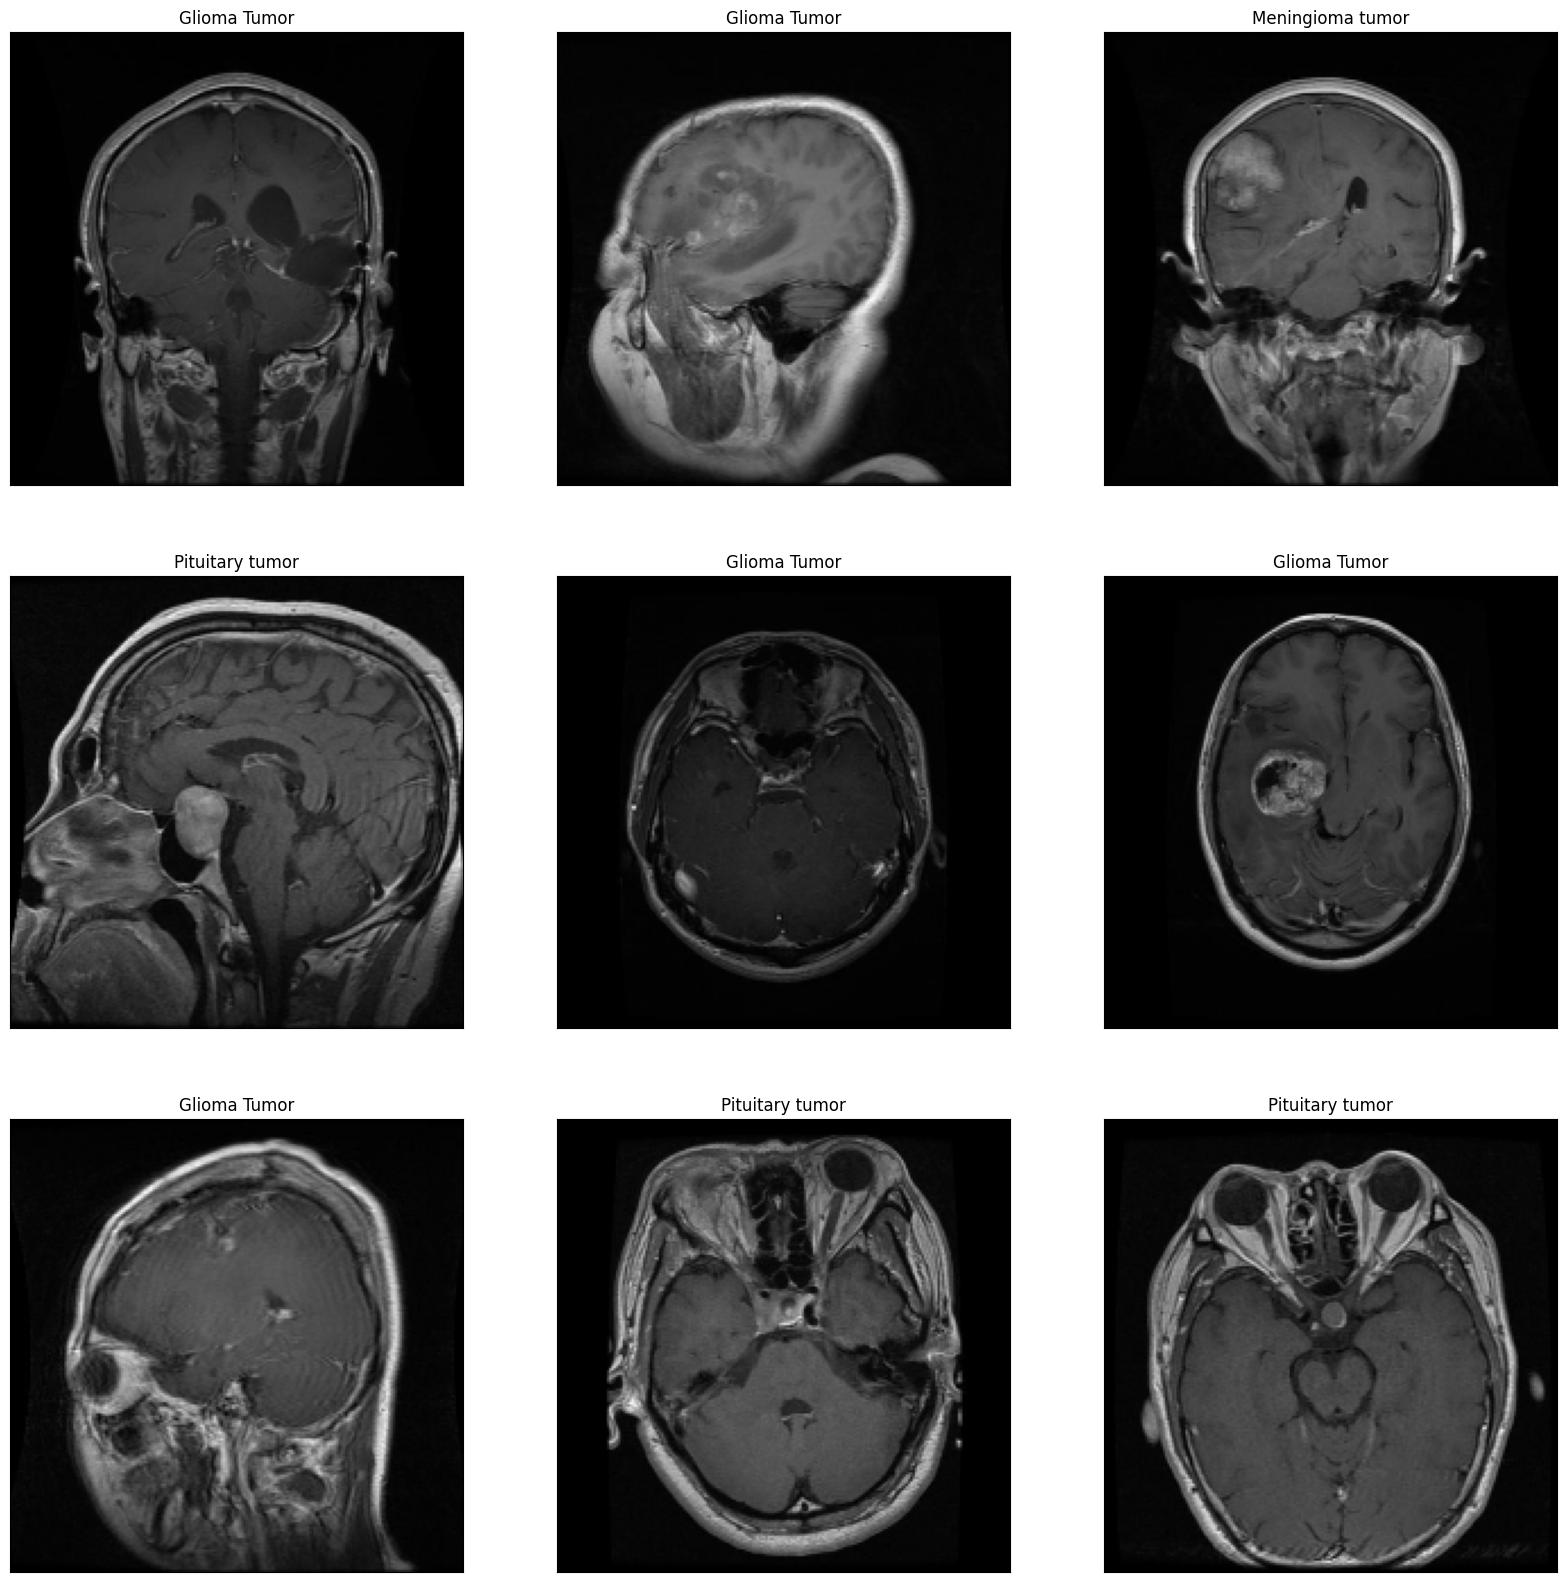

In [26]:
plt.figure(figsize=(20,20))

for k in range(9):
    plt.subplot(3, 3, k+1)
    plt.imshow(X_val[k],cmap=plt.cm.binary)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.title(class_names[Y_val[k]])
plt.show()

# <span style='color: olive' > Normalize the pixel values of the images to the range [0, 1] </span>

In [7]:
# Normalize the pixel values of the images to the range [0, 1]
x_test_tensorflow = X_test.copy() / 255.0
x_train_tensorflow = X_train.copy() / 255.0
X_val = X_val.copy()/255.0

# Print the range of normalized pixel values for both training and testing datasets
print('Normalized pixel values in training dataset: '
      ' min={}, max={}'.format(x_train_tensorflow.min(), x_train_tensorflow.max()))
print('Normalized pixel values in testing dataset: '
      ' min={}, max={}'.format(x_test_tensorflow.min(), x_test_tensorflow.max()))



Normalized pixel values in training dataset:  min=0.0, max=1.0
Normalized pixel values in testing dataset:  min=0.0, max=1.0


# #######################################################################################################
# Implement the model
# #######################################################################################################

In [8]:
class My_model(tf.keras.Model):
    def __init__(self):
        super(My_model, self).__init__()
        self.flatten = tf.keras.layers.Flatten( )
        #First layer
        self.layer1 = tf.keras.layers.Dense(units=200,activation='relu',
                                            use_bias=True)
        
        self.layer2= tf.keras.layers.Dense(units=200,
                                           activation='relu',
                                           use_bias=True)
        self.outputt = tf.keras.layers.Dense(units=4)

    def call(self, inputs):
        x= self.flatten(inputs) 
        x = self.layer1(x)
        x= self.layer2(x)
        output = self.outputt(x)
        return output

         


# #######################################################################################################
# Train the model and analyze its performance.
# #######################################################################################################

In [13]:
class Use_Model(object):

    def __init__(self, train_data, val_data,
                 test_data, train_labels,
                 val_labels, test_labels):
        self.train_data= train_data
        self.val_data=val_data
        self.test_data=test_data
        self.train_labels=train_labels
        self.val_labels =val_labels
        self.test_labels = test_labels
        self.boxplot = False
        self.model =None

        self.target_names = ['No tumor', 'Glioma tumors', 'Meningioma tumors','Pituitary tumors']

        self.opt_base = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)
        self.early_stroping = EarlyStopping(
            monitor='val_loss',
            min_delta=0,
            patience=8,
            verbose=0,
            mode='min',
            baseline=None,
            restore_best_weights=True,
            start_from_epoch=0
            )


    def compile_model(self):
        
        if self.model is None:
            self.model = My_model()
            dummy_input = tf.zeros((1, 200, 200, 3))
            self.model(dummy_input)  # Call model with dummy input
        
            self.model.compile(
                    optimizer=self.opt_base,
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy']
                )
        
    def Fit(self, seed=False):

        if seed:
            seed = 163
            
            keras.utils.set_random_seed(seed)

        self.compile_model()
        self.model.summary()

        
        self.history=self.model.fit(self.train_data,
                                    self.train_labels,  epochs=100,
                                    callbacks=[self.early_stroping],
                                    validation_data=(self.val_data, self.val_labels),
                                    verbose=0)
        return self.history
    
    
        
    def make_boxplot(self, num_accuracies, boxplot=False):
        self.boxplot= boxplot
        self.num_accuracies=num_accuracies
        accuracies = np.zeros(self.num_accuracies)
        losses = np.zeros(self.num_accuracies)


        
        for k in range(self.num_accuracies):
            model_instance = My_model()

            dummy_input = tf.zeros((1, 200, 200, 3))
            model_instance(dummy_input)

            model_instance.compile(optimizer = self.opt_base,
                                   loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                                   metrics= ['accuracy'])
            model_instance.fit(self.train_data,
                                    self.train_labels,  epochs=100,
                                    callbacks=[self.early_stroping],
                                    validation_data=(self.val_data, self.val_labels),
                                    verbose=0)
            
            # Evaluate the new model instance on the test data
            loss, acc= model_instance.evaluate(self.test_data, self.test_labels, verbose =0)
            accuracies[k]= acc
            losses[k] = loss
        accuracies= accuracies*100

        #  Compute mean and standard deviation for accuracies and losses
        mean_accuracy = np.mean(accuracies)
        std_accuracy = np.std(accuracies)

        mean_loss = np.mean(losses)
        std_losses = np.std(losses)


        # Remove outliers
        # Values that are greater than +3 standard deviations from the mean, 
        # or less than -3 standard deviations, are included as outliers in the output results
        threshold_loss = 3 * std_losses
        threshold_accuracy = 3 * std_accuracy
        accuracies = accuracies[(accuracies >= mean_accuracy - threshold_accuracy) & (accuracies <= mean_accuracy + threshold_accuracy)]
        losses = losses[(losses >= mean_loss - threshold_loss) & (losses <= mean_loss + threshold_loss)]


        # Compute confidence interval
        ci_accuracy = 1.96 * (std_accuracy / np.sqrt(len(accuracies)))
        ci_losses = 1.96 * (std_losses / np.sqrt(len(losses)))

        
            
            
        if boxplot:
            fig, axs = plt.subplots(2, 2, figsize=(10,6))
            boxplot1 = axs[0,0].boxplot(accuracies, capprops = dict(color = "red", linewidth = 2),
               whiskerprops = dict(color = "blue", linewidth = 2), patch_artist = True,
                boxprops = dict(facecolor = "yellow"), vert=False,
                        showmeans =True)
            
            for box in boxplot1['boxes']:
                box.set_linewidth(2)
            
            axs[0, 0].set_xlabel(f'Mean Accuracy: {np.mean(accuracies):.2f}%,  SD : {np.std(accuracies):.2f}', color='olive')
            axs[0, 0].set_title(f'Distribution (boxplot) of Model Accuracies ({len(accuracies)} runs)', color='blue')

            

            sns.kdeplot(accuracies, shade=True, color="blue", lw=3, ax=axs[0, 1])
            axs[0, 1].set_title(f'Density Plot of Model Accuracies ({len(accuracies)} runs)', color='blue')
            axs[0,1].axvline(x=mean_accuracy, color='red', linestyle='--',lw=2, label='Mean')
            axs[0,1].axvline(x=mean_accuracy - ci_accuracy, color='green', lw=2, linestyle='--', label='95% CI')
            axs[0,1].axvline(x=mean_accuracy + ci_accuracy, color='green', lw=2,  linestyle='--')
            axs[0,1].legend()

            # Losses

            boxplot2= axs[1, 0].boxplot(losses, capprops=dict(color="red", linewidth=2),
                  whiskerprops=dict(color="blue", linewidth=2), patch_artist=True,
                  boxprops=dict(facecolor="yellow"), vert=False,
                  showmeans=True)
            for box in boxplot2['boxes']:
                box.set_linewidth(2)

            axs[1, 0].set_title(f'Distribution(boxplot) of Model Losses ({len(losses)} runs)', color='blue')
            axs[1, 0].set_xlabel(f'Mean Loss: {np.mean(losses):.4f}, SD Loss: {np.std(losses):.4f} ', color='olive')

            sns.kdeplot(losses, shade=True, color="blue", lw=3, ax=axs[1, 1])
            axs[1, 1].set_title(f'Density Plot of Model Losses ({len(losses)} runs)', color='blue')

            axs[1,1].axvline(x=mean_loss, color='red', linestyle='--',lw=2, label='Mean')
            axs[1,1].axvline(x=mean_loss - ci_losses, color='green', lw=2,  linestyle='--', label='95% CI')
            axs[1,1].axvline(x=mean_loss + ci_losses, color='green', lw=2,  linestyle='--')

            axs[1,1].legend()

            fig.tight_layout()

            plt.show()
        else:
            print('Nothing to show')

      
    def predic_proba_and_labels(self):
        self.y_pred_base = self.model.predict(self.test_data)

        # Since the output layer is not activated using soft max, we...

        self.y_pred_probabilities = tf.nn.softmax(self.y_pred_base, axis=1)

        # Now, if we want to get the predicted class labels, you can use argmax
        self.predicted_classes = np.argmax(self.y_pred_probabilities, axis=1)

        return self.y_pred_probabilities, self.predicted_classes


    def Show_Classification_Report (self):
        print('Printing the Classification Report \n')
        
        print(classification_report(self.predicted_classes, self.test_labels, target_names=self.target_names))
        print('')

    def Display_Confusion_Matrix(self):
        cm = confusion_matrix(self.test_labels, self.predicted_classes)
        disp_base = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                   display_labels=self.target_names)
        disp_base.plot()
        plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
        plt.show()  

    def plot_training_history(self):
        plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'],'*-', lw=2, color='magenta', 
                  label ='Training Accuracy')
        plt.plot(self.history.history['val_accuracy'],'.-', lw=2, color='brown',
                  label ='Validation Accuracy')
        plt.xlabel('Epochs', color='green',fontsize=13)
        plt.ylim(0.2, 1.1)
        plt.ylabel('Accuracy', color='green', fontsize=13)
        plt.legend()
        plt.grid()
        plt.title('Training and Validation Accuracy over Epochs', color='blue')
        

        plt.subplot(1, 2, 2)

        plt.plot(self.history.history['loss'],'*-', lw=2, color='magenta', label ='Training loss')
        plt.plot(self.history.history['val_loss'],'.-', lw=2, color='brown', label ='Validation loss')
        plt.xlabel('Epochs', color='green', fontsize=13)
        plt.ylabel('Loss', color='green', fontsize=13)
        plt.legend()
        plt.grid()
        plt.title('Training and Validation Loss over Epochs', color='blue')
        plt.show()


    def Predict_Tumor_Type(self, image):
        image = np.expand_dims(image, axis=0)
        raw_pred = self.model.predict(image)
        self.y_pred_pr = tf.nn.softmax(raw_pred, axis=1)
        predicted = np.argmax(self.y_pred_pr, axis=1)[0]

        predicted_tumor_type = class_names[predicted]
        print('Based on this image, our prediction is that the patient has {}'.format(predicted_tumor_type))

        



# #######################################################################################################
# Test the model
# #######################################################################################################

Pass or No Pass 


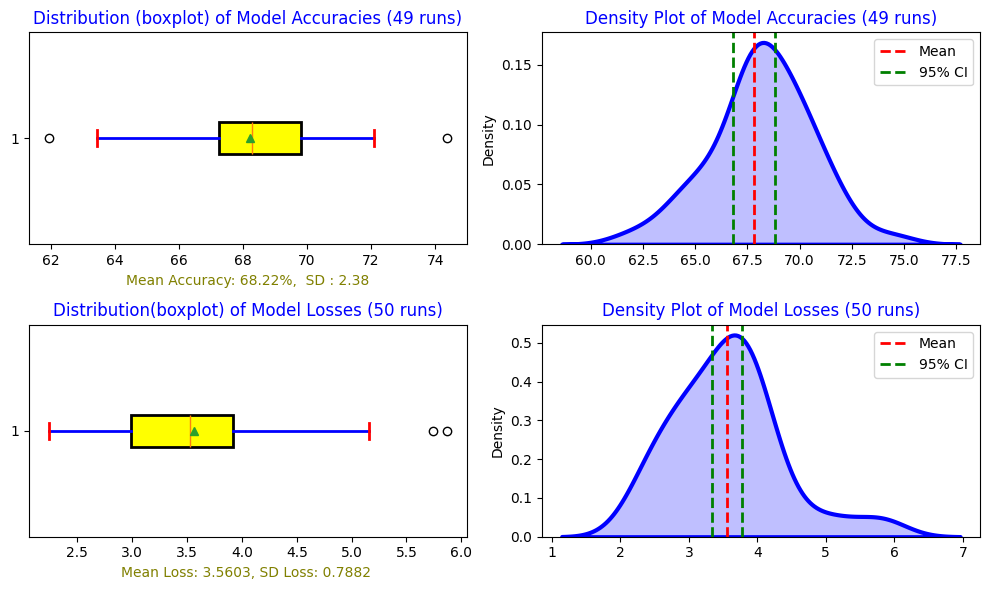

In [12]:
model_use_statistics = Use_Model( x_train_tensorflow, X_val, x_test_tensorflow, Y_train, Y_val, Y_test)

#model_use.Fit(  seed=False)

model_use_statistics.make_boxplot(50, boxplot=True)



Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  24000200  
                                                                 
 dense_1 (Dense)             multiple                  40200     
                                                                 
 dense_2 (Dense)             multiple                  804       
                                                                 
Total params: 24041204 (91.71 MB)
Trainable params: 24041204 (91.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
13/13 [==============================] - 0s 6ms/step


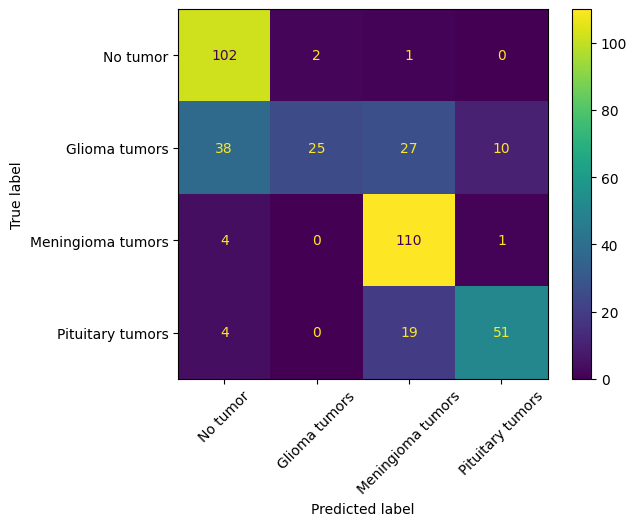

Printing the Classification Report 

                   precision    recall  f1-score   support

         No tumor       0.97      0.69      0.81       148
    Glioma tumors       0.25      0.93      0.39        27
Meningioma tumors       0.96      0.70      0.81       157
 Pituitary tumors       0.69      0.82      0.75        62

         accuracy                           0.73       394
        macro avg       0.72      0.78      0.69       394
     weighted avg       0.87      0.73      0.77       394




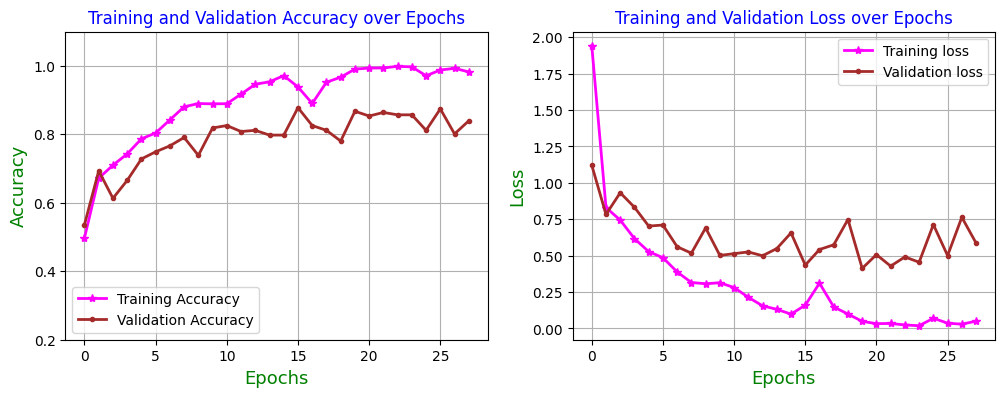

In [11]:
model_use = Use_Model( x_train_tensorflow, X_val, x_test_tensorflow, Y_train, Y_val, Y_test)

model_use.Fit(  seed=True)

y_pred_probabilities, predicted_classes =model_use.predic_proba_and_labels()

model_use.Display_Confusion_Matrix()

model_use.Show_Classification_Report()
model_use.plot_training_history()

0.8063855421686746

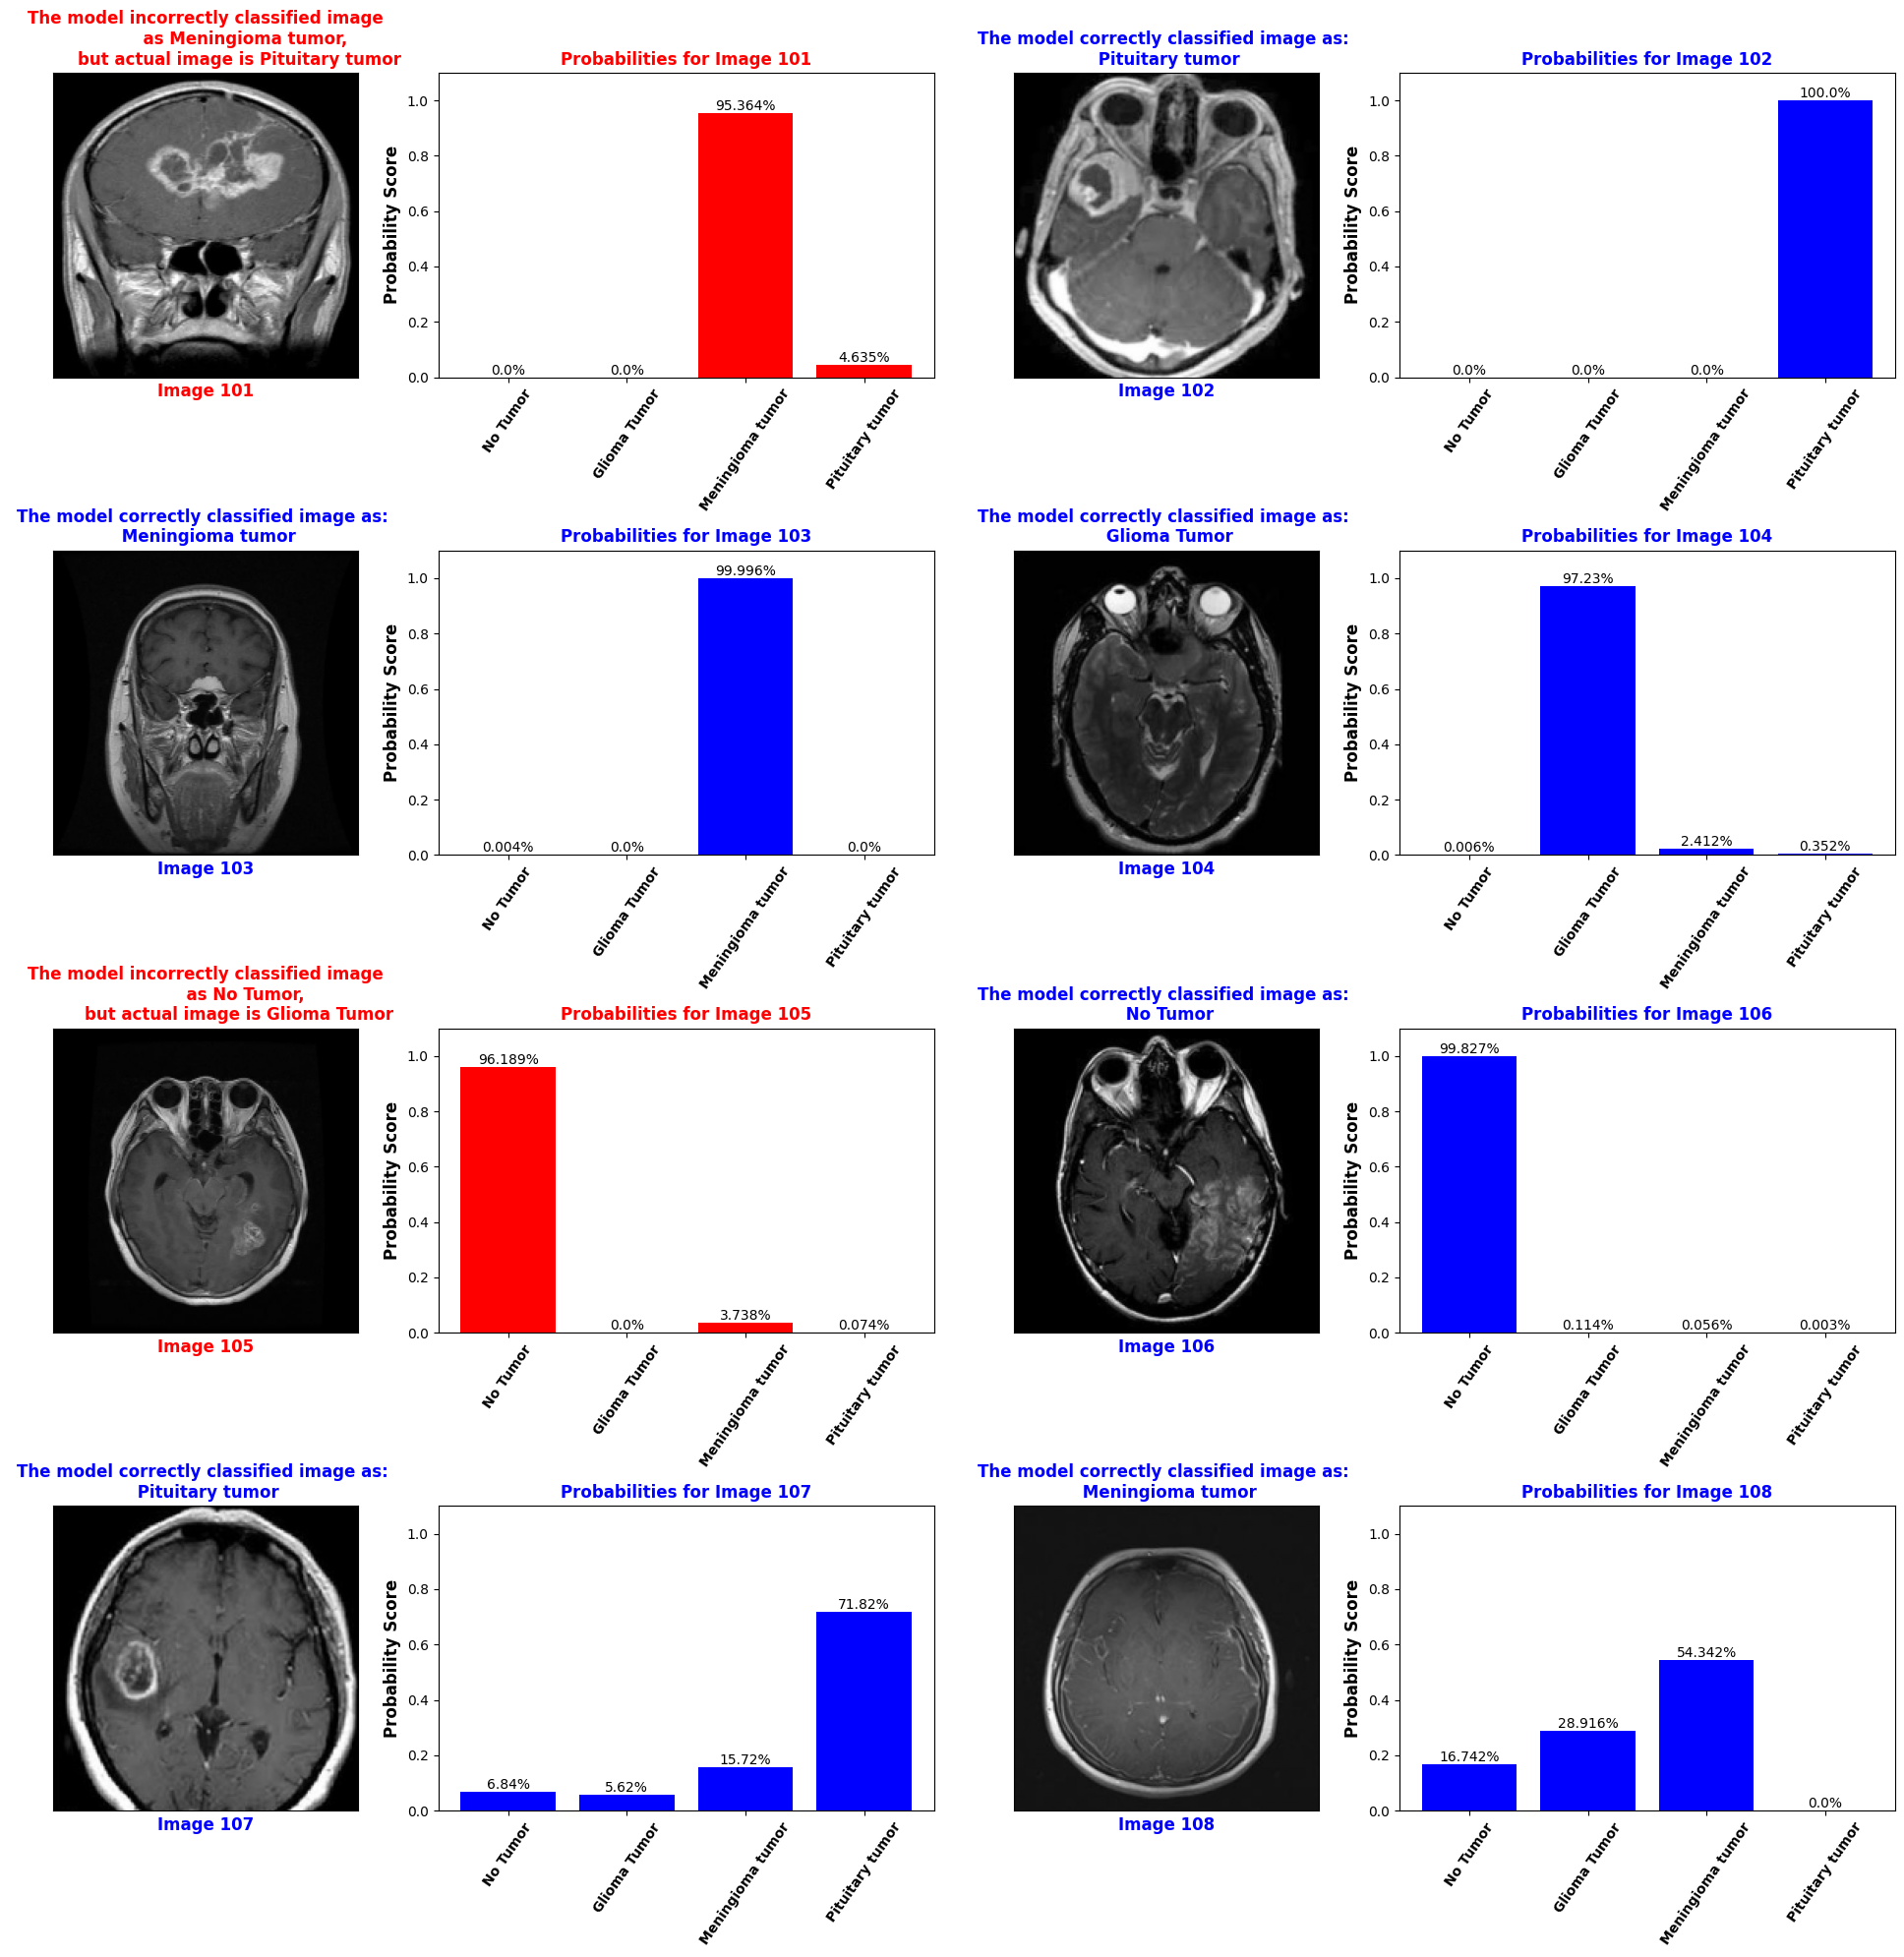

In [22]:
def plot_with_prob(index_start,index_finish,  probs, true_label, images):
    n = int(index_finish-index_start )
    predicted_label = np.argmax(probs[index_start: index_finish], axis=1)
    probs = probs[index_start: index_finish].numpy()
    true_label = true_label[index_start: index_finish]

    n_plots = int(2*n)
    n_cols = int( np.floor(np.sqrt(n_plots))  )
    n_rows = int(np.ceil(np.sqrt(n_plots)))

    def add_percentage_on_bars(x, y):
        for index in range(len(x)):
            value_probability = y[index]
            value_percent =np.round(value_probability*100, 3)
            plt.text(index, value_probability, str(value_percent)+'%',
                     ha='center', va='bottom')
        

    tumor_types = [class_names[i] for i in range(4)]
    plt.figure(figsize=(20,20))
    for num_plots, index in enumerate(range(n)):
        if true_label[index]== predicted_label[index]:
            color ='blue'
            title_image = f'The model correctly classified image as: \n {class_names[true_label[index]]}'
        else:
            color = 'red'
            title_image =title_image = f'''The model incorrectly classified image
              as {class_names[predicted_label[index]]},
            but actual image is {class_names[true_label[index]]}'''
            #pass
        plt.subplot(n_rows, n_cols, 1+num_plots*2)
        plt.imshow(images[index],cmap=plt.cm.binary)
        plt.title(title_image, fontsize=12, color=color, weight='bold')
        plt.xlabel('Image {}'.format(index+index_start), c=color,
                   fontsize= 12,  weight='bold')
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(n_rows, n_cols, 2+num_plots*2)
        plt.bar(tumor_types, probs[index], color=color)
        plt.ylim([0,1.1])
        add_percentage_on_bars(tumor_types,probs[index] )
        plt.ylabel('Probability Score', fontsize=12, weight='bold')
        plt.title('Probabilities for Image {}'.format(index+index_start), 
                  color=color,fontsize= 12,  weight='bold')
        plt.xticks(tumor_types, rotation=55,weight='bold')
        plt.tight_layout()
    plt.show()

plot_with_prob(101,109,  y_pred_probabilities, Y_test, x_test_tensorflow) 
